# Regression model — simulation

This notebook explores and models the data collected from recordings of the natural acoustic environment over the urban-rural gradient near Innsbruck, Austria. The models are implemented as Bayesian models with the PyMC3 probabilistic programming library.

References:<br />
https://github.com/fonnesbeck/multilevel_modeling<br />
Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

#### Import statements

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas
import numpy
from os import path

In [3]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import seaborn
import mpld3
from mpld3 import plugins

In [4]:
from pymc3 import glm, Model, NUTS, sample, stats, \
                  forestplot, traceplot, plot_posterior, summary, \
                  Normal, Uniform, Deterministic, StudentT
from pymc3.backends import SQLite

#### Plot settings

In [5]:
from matplotlib import rcParams

In [6]:
rcParams['font.sans-serif']

['Arial', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

In [7]:
rcParams['font.sans-serif'] = ['Helvetica',
                               'Arial',
                               'Bitstream Vera Sans',
                               'DejaVu Sans',
                               'Lucida Grande',
                               'Verdana',
                               'Geneva',
                               'Lucid',
                               'Avant Garde',
                               'sans-serif']

#### Variable definitions

In [8]:
data_filepath = "/Users/Jake/OneDrive/Documents/alpine soundscapes/data/dataset.csv"

In [9]:
trace_output_path = "/Users/Jake/OneDrive/Documents/alpine soundscapes/data/model traces/biophony"

In [10]:
seaborn_blue = seaborn.color_palette()[0]

## Load data

In [11]:
data = pandas.read_csv(data_filepath)
data = data.loc[data.site<=30]

sort data by site and then by visit

In [12]:
data_sorted = data.sort_values(by=['site', 'sound']).reset_index(drop=True)

create composite land cover variable

In [13]:
data_sorted['land_composite_50m'] = data_sorted.forest_50m - (data_sorted.building_50m + data_sorted.pavement_50m)
data_sorted['land_composite_100m'] = data_sorted.forest_100m - (data_sorted.building_100m + data_sorted.pavement_100m)
data_sorted['land_composite_200m'] = data_sorted.forest_200m - (data_sorted.building_200m + data_sorted.pavement_200m)
data_sorted['land_composite_500m'] = data_sorted.forest_500m - (data_sorted.building_500m + data_sorted.pavement_500m)

transform variables (mean center)

In [14]:
column_list = ['anthrophony', 'biophony', 'total', 'week', 
    'building_50m', 'pavement_50m', 'forest_50m', 'field_50m',
    'building_100m', 'pavement_100m', 'forest_100m', 'field_100m',
    'building_200m', 'pavement_200m', 'forest_200m', 'field_200m',
    'building_500m', 'pavement_500m', 'forest_500m', 'field_500m',
    'land_composite_50m', 'land_composite_100m', 'land_composite_200m', 'land_composite_500m',
    'temperature', 'wind_speed', 'pressure', 'bus_stop',
    'construction', 'crossing', 'cycleway', 'elevator', 'escape', 'footway',
    'living_street', 'motorway', 'motorway_link', 'path', 'pedestrian',
    'platform', 'primary_road', 'primary_link', 'proposed', 'residential',
    'rest_area', 'secondary', 'secondary_link', 'service', 'services',
    'steps', 'tertiary', 'tertiary_link', 'track', 'unclassified', 'combo']

data_centered = data_sorted
for column in column_list:
    data_centered[column] = data_sorted[column] - data_sorted[column].mean()

create sites variable for PyMC3 models

In [15]:
sites = numpy.copy(data_sorted.site.values) - 1

## Model 1—time and site predictors

$$
\begin{align}
\text{level 1} \\
y_{ts} \sim \mathcal{N}(\alpha_s + \beta_s T_t, \sigma_y^2) \\
\text{level 2} \\
\alpha_s \sim \mathcal{N}(\gamma_\alpha + \gamma_{\alpha s} L_s, \sigma_\alpha^2) \\
\beta_s \sim \mathcal{N}(\gamma_\beta + \gamma_{\beta s} L_s, \sigma_\beta^2) \\
\end{align}
$$

In [70]:
with Model() as model_1:

    # intercept
    g_a = Normal('g_a', mu=0, tau=0.001)
    g_as = Normal('g_as', mu=0, tau=0.001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    mu_a = g_a + (g_as * data_centered.groupby('site')['land_composite_200m'].mean())
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))

    # slope
    g_b = Normal('g_b', mu=0, tau=0.001)
    g_bs = Normal('g_bs', mu=0, tau=0.001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    mu_b = g_b + (g_bs * data_centered.groupby('site')['land_composite_200m'].mean())
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))

    # model error (data-level)
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2

    # expected values
    y_hat = a[sites] + (b[sites] * data_centered.week)

    # likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data_centered.biophony)

    # simulated
    y_sim = Normal('y_sim', mu=y_hat, tau=tau_y, shape=y_hat.tag.test_value.shape)

    # sample model
    backend = SQLite(path.join(trace_output_path, "model3.sqlite"))
    model_1_samples = sample(draws=10000, step=NUTS(), random_seed=1, trace=backend)

Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.
100%|██████████| 10000/10000 [07:26<00:00, 22.36it/s]


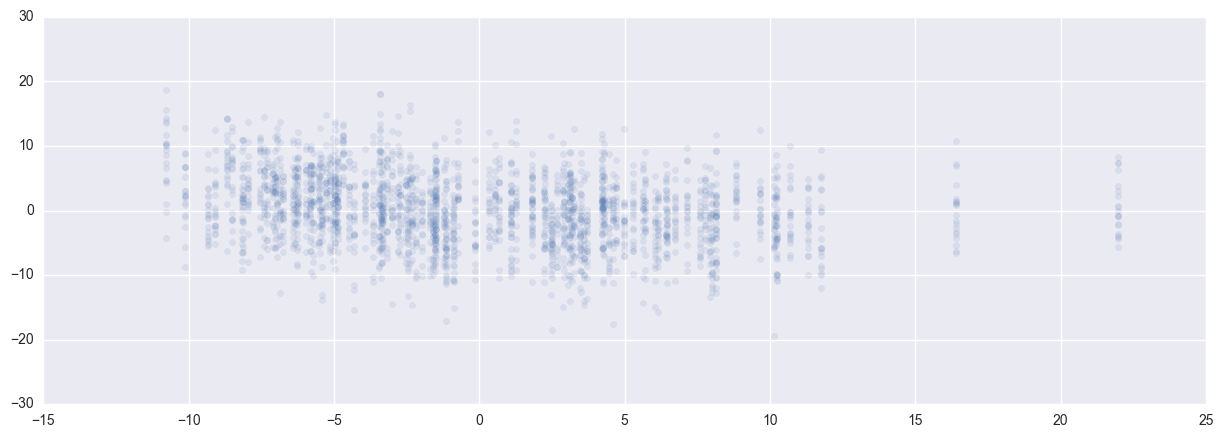

In [68]:
# mean site-level parameter means
g_a = trace['g_a'].mean()
g_as = trace['g_as'].mean()
g_b = trace['g_b'].mean()
g_bs = trace['g_bs'].mean()

# calculate predicted biophony
y_hat = numpy.empty(len(data_centered))
for i, row in data_centered.iterrows():
    a = g_a + (g_as * row['land_composite_200m'])
    b = g_b + (g_bs * row['land_composite_200m'])
    y_hat[i] = a + (b * row['week'])

fig, ax = pyplot.subplots()
fig.set_figwidth(15)
fig.set_figheight(5)
#ax.scatter(data_centered['land_composite_200m'], y_hat, color='black')

# plot simulated
for s in numpy.random.randint(0, 4999, 20):
    y_sim = trace.y_sim[s, :]
    y_e = y_hat - y_sim
    ax.scatter(data_centered['biophony'], y_e, color=seaborn_blue, alpha=0.1)